# Transport Model Classification using a Bidirectional LSTM
## (Hyperparam Tuning)
To better understand the code, check out `./prep_files/biLSTM_transport_classification.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point. 

In [2]:
import numpy as np
import pandas as pd
import torch
from torchsummary import summary

from src.engine import biLSTM_engine
from src.model_transportMode import BiLSTMNetwork
from src.dataset import TransportModeDataset
from src.hyperparam import RayTuning
from ray import tune, train

from IPython.display import display, HTML

# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">')  # Ensure the path is correct
display(css)

In [3]:
model = BiLSTMNetwork(input_size=6, hidden_size=512, num_layers=2)
summary(model, verbose=0)

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              8,429,568
├─Linear: 1-2                            8,200
├─ReLU: 1-3                              --
Total params: 8,437,768
Trainable params: 8,437,768
Non-trainable params: 0

In [4]:
model

BiLSTMNetwork(
  (lstm): LSTM(6, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=8, bias=True)
  (relu): ReLU()
)

In [5]:
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn
import torch.optim as optim

#### Hyperparameter tuning of Model

In [6]:
y_train = pd.read_csv('./data/lstm_features_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

del y_train

Classes: [0. 1. 2. 3. 4. 5. 6. 7.]


Original coarse labels are shown below. During preprocessing, the Null class (`0.0`), was dropped and with the remaining, I substracted `1` from the labels so that it would start from `0`.

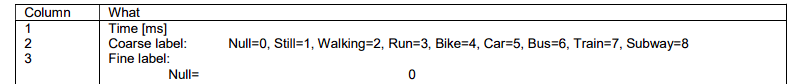

In [7]:
base_dir = './data/lstm_features_labels/'

train_datasets = TransportModeDataset(base_dir, mode='train')
val_test_datasets = TransportModeDataset(base_dir, mode='valid')

In [15]:
from torch.utils.data import random_split, DataLoader

In [9]:
np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

In [10]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [11]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(0.005, 0.5),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.90, 0.95),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([1200]),
    "batch_size": tune.choice([32, 64, 128]),
    "weight_decay": tune.loguniform(0.005, 0.5),
    "hidden_size": tune.choice([50, 100, 150, 200, 250, 300]),
    "num_layers": tune.choice([1, 2, 3]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'BiLSTM'
model = BiLSTMNetwork
modelType = 'BiLSTM'
engine = biLSTM_engine

In [12]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [13]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=40)

(train_model pid=15820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/BiLSTM/trial_cf6ae_00000/checkpoint_000000)
(train_model pid=15820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/BiLSTM/trial_cf6ae_00000/checkpoint_000001)
(train_model pid=15820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/BiLSTM/trial_cf6ae_00000/checkpoint_000002)
(train_model pid=15820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/wo

Best trial config: {'optimizer': 'adamw', 'lr': 0.007696965501070433, 'scheduler': 'exp', 'gamma': 0.9318166309092948, 'patience': 10, 'epochs': 1200, 'batch_size': 64, 'weight_decay': 0.07563306484196267, 'hidden_size': 300, 'num_layers': 1, 'dropout': 0.494696861183782}
Best trial final validation loss: 0.7462075460743118
Best trial final validation accuracy: 67.2951%


c:\Users\LEGION\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.494696861183782 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Test Loss: 0.8065, Test Accuracy: 68.52%


TypeError: unsupported format string passed to tuple.__format__

It looks like it favours;
* num_layers = 1
* batch_size = 64
* hidden_size = 200-300
* learning rate = 0.00769697 - 0.00965392 
* weight_decay(*) = 0.005 - 0.01

Let's see the performance of the 'best config'

In [16]:
batch_size = 64
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [17]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = BiLSTMNetwork(input_size=6, hidden_size=300, num_layers=1, dropout=0.494697)
optimizer = optim.AdamW(model.parameters(), lr=0.00769697, weight_decay=0.0756331)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.931817)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

c:\Users\LEGION\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.494697 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [18]:
engine = biLSTM_engine(model, optimizer, scheduler, criterion, device)

In [19]:
hist = engine.train_validation(train_dl, valid_dl, epochs=1200, save_path=None)

   Epoch [1/1200], Train Loss: 1.4008, Train Accuracy: 41.19%, Val Loss: 1.1682, Val Accuracy: 50.50%
   Epoch [2/1200], Train Loss: 1.1863, Train Accuracy: 51.04%, Val Loss: 1.1167, Val Accuracy: 52.87%
   Epoch [3/1200], Train Loss: 1.0640, Train Accuracy: 55.16%, Val Loss: 0.9979, Val Accuracy: 56.42%
   Epoch [4/1200], Train Loss: 1.0017, Train Accuracy: 57.49%, Val Loss: 0.9553, Val Accuracy: 59.08%
   Epoch [5/1200], Train Loss: 0.9555, Train Accuracy: 59.52%, Val Loss: 0.9725, Val Accuracy: 58.09%
   Epoch [6/1200], Train Loss: 0.8975, Train Accuracy: 62.22%, Val Loss: 0.9244, Val Accuracy: 61.40%
   Epoch [7/1200], Train Loss: 0.8870, Train Accuracy: 62.61%, Val Loss: 0.8505, Val Accuracy: 63.13%
   Epoch [8/1200], Train Loss: 0.8216, Train Accuracy: 65.49%, Val Loss: 0.8123, Val Accuracy: 65.98%
   Epoch [9/1200], Train Loss: 0.7931, Train Accuracy: 66.77%, Val Loss: 0.7884, Val Accuracy: 65.57%
   Epoch [10/1200], Train Loss: 0.7606, Train Accuracy: 67.97%, Val Loss: 0.7646, 

KeyboardInterrupt: 

In [22]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(0.005, 0.01),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.90, 0.95),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([50]),
    "batch_size": tune.choice([64, 128]),
    "weight_decay": tune.loguniform(0.005, 0.01),
    "hidden_size": tune.choice([200, 250, 300]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.5, 1)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'BiLSTM'
model = BiLSTMNetwork
modelType = 'BiLSTM'
engine = biLSTM_engine

In [23]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [24]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=40)

(train_model pid=21012) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/BiLSTM/trial_4c453_00000/checkpoint_000000)
(train_model pid=21012) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/BiLSTM/trial_4c453_00000/checkpoint_000001)
(train_model pid=21012) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/BiLSTM/trial_4c453_00000/checkpoint_000002)
(train_model pid=21012) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/wo

2024-07-30 11:44:09,549	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/BiLSTM' in 0.0400s.
2024-07-30 11:44:09,599	INFO tune.py:1041 -- Total run time: 10460.00 seconds (10459.87 seconds for the tuning loop).


Best trial config: {'optimizer': 'adamw', 'lr': 0.005198989965043782, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.9383597426554285, 'patience': 5, 'epochs': 50, 'batch_size': 64, 'weight_decay': 0.008375293519355285, 'hidden_size': 300, 'num_layers': 1, 'dropout': 0.618753235646235}
Best trial final validation loss: 0.6986686010937114
Best trial final validation accuracy: 71.3248%


c:\Users\LEGION\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.618753235646235 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Test Loss: 0.7565, Test Accuracy: 71.53%


TypeError: unsupported format string passed to tuple.__format__